In [1]:
%load_ext autoreload
%autoreload 1
%aimport functions.helpers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from functions.helpers import convert_feature_types

/home/estacio/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Dataset reference: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success
- Competition site: https://www.kaggle.com/competitions/playground-series-s4e6/overview

# Load dataset

In [23]:
df = pd.read_csv('./datasets/train.csv', index_col='id')
print(f'Dataframe before drop_duplicates: {len(df)}')
df.drop_duplicates(inplace=True)
print(f'Dataframe after drop_duplicates: {len(df)}')
df.head()

Dataframe before drop_duplicates: 76518
Dataframe after drop_duplicates: 76518


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [24]:
df = convert_feature_types(df)
df['Curricular units 1st sem (grade) >= 10'] = df['Curricular units 1st sem (grade)']>=10
df['Curricular units 2nd sem (grade) >= 10'] = df['Curricular units 2nd sem (grade)']>=10
y = df['Target']
X = df.drop(['Target'], axis=1)
X.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Curricular units 1st sem (grade) >= 10,Curricular units 2nd sem (grade) >= 10
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,6,7,6,12.428571,0,11.1,0.6,2.02,True,True
1,1,17,1,9238,1,1,125.0,1,19,19,...,6,9,0,0.000000,0,11.1,0.6,2.02,True,False
2,1,17,2,9254,1,1,137.0,1,3,19,...,6,0,0,0.000000,0,16.2,0.3,-0.92,False,False
3,1,1,3,9500,1,1,131.0,1,19,3,...,8,11,7,12.820000,0,11.1,0.6,2.02,True,True
4,1,1,2,9500,1,1,132.0,1,19,37,...,7,12,6,12.933333,0,7.6,2.6,0.32,True,True


# Data Exploration

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [10]:
# valores faltantes
df.isnull().sum().sum()

0

In [12]:
df.select_dtypes(include='object')

,Target
id,
0,Graduate
1,Dropout
2,Dropout
3,Enrolled
4,Graduate
...,...
76513,Graduate
76514,Graduate
76515,Enrolled


### Variáveis
- Marital Status: numbers -> Transform into categorical var
- Application mode: numbers -> Transform into categorical var
- Course: numbers -> Transform into categorical var
- Daytime/evening attendance -> transform into categorical var
- Previous qualification -> transform into categorical var
- previous qualification (grade) -> looks like numerical
- Nacionality -> transform into categorical var
- Mother's qualification -> transform into cat var
- Father's qualification -> transform into cat var
- Mother's occupation -> transform into cat var
- Father's occupation -> transform into cat var
- Addmission grade -> looks numericals
- Displaced -> transform into binary var
- Educational special needs -> binary var
- Debtor -> binary var
- Tuition fees up to date -> binary var
- Gender -> binary var
- Scholarship holder -> binary var
- Age at enrollment -> numerical var (ok)
- International -> binary var
- Curricular units -> I'm not sure what this is.

In [4]:
df = convert_feature_types(df)

In [5]:
df.dtypes

Marital status                                    category
Application mode                                  category
Application order                                 category
Course                                            category
Daytime/evening attendance                        category
Previous qualification                            category
Previous qualification (grade)                     float64
Nacionality                                       category
Mother's qualification                            category
Father's qualification                            category
Mother's occupation                               category
Father's occupation                               category
Admission grade                                    float64
Displaced                                         category
Educational special needs                         category
Debtor                                            category
Tuition fees up to date                           catego

<Axes: xlabel='Target', ylabel='count'>

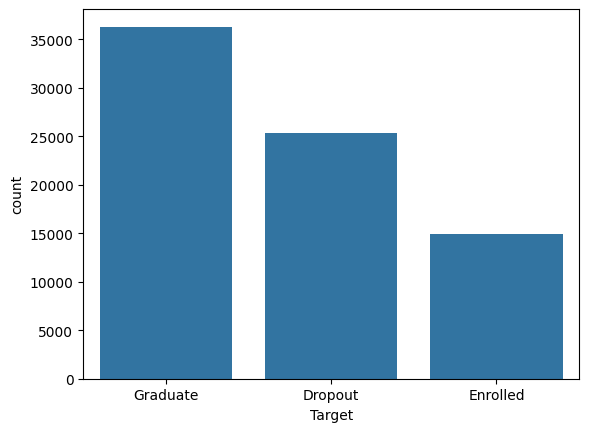

In [6]:
sns.barplot(y.value_counts())

### Comparison between train and test datasets

In [22]:
df_train =  pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [23]:
df_test['dataset'] = ['test']*len(df_test)

In [24]:
df_train['dataset'] = ['train']*len(df_train)

In [25]:
df_complete = pd.concat([df_train, df_test])
df_complete.drop('Target', axis=1, inplace=True)

In [53]:
df_complete = convert_feature_types(df_complete)
num_variables = df_complete.select_dtypes(include=['float64']).columns.tolist()

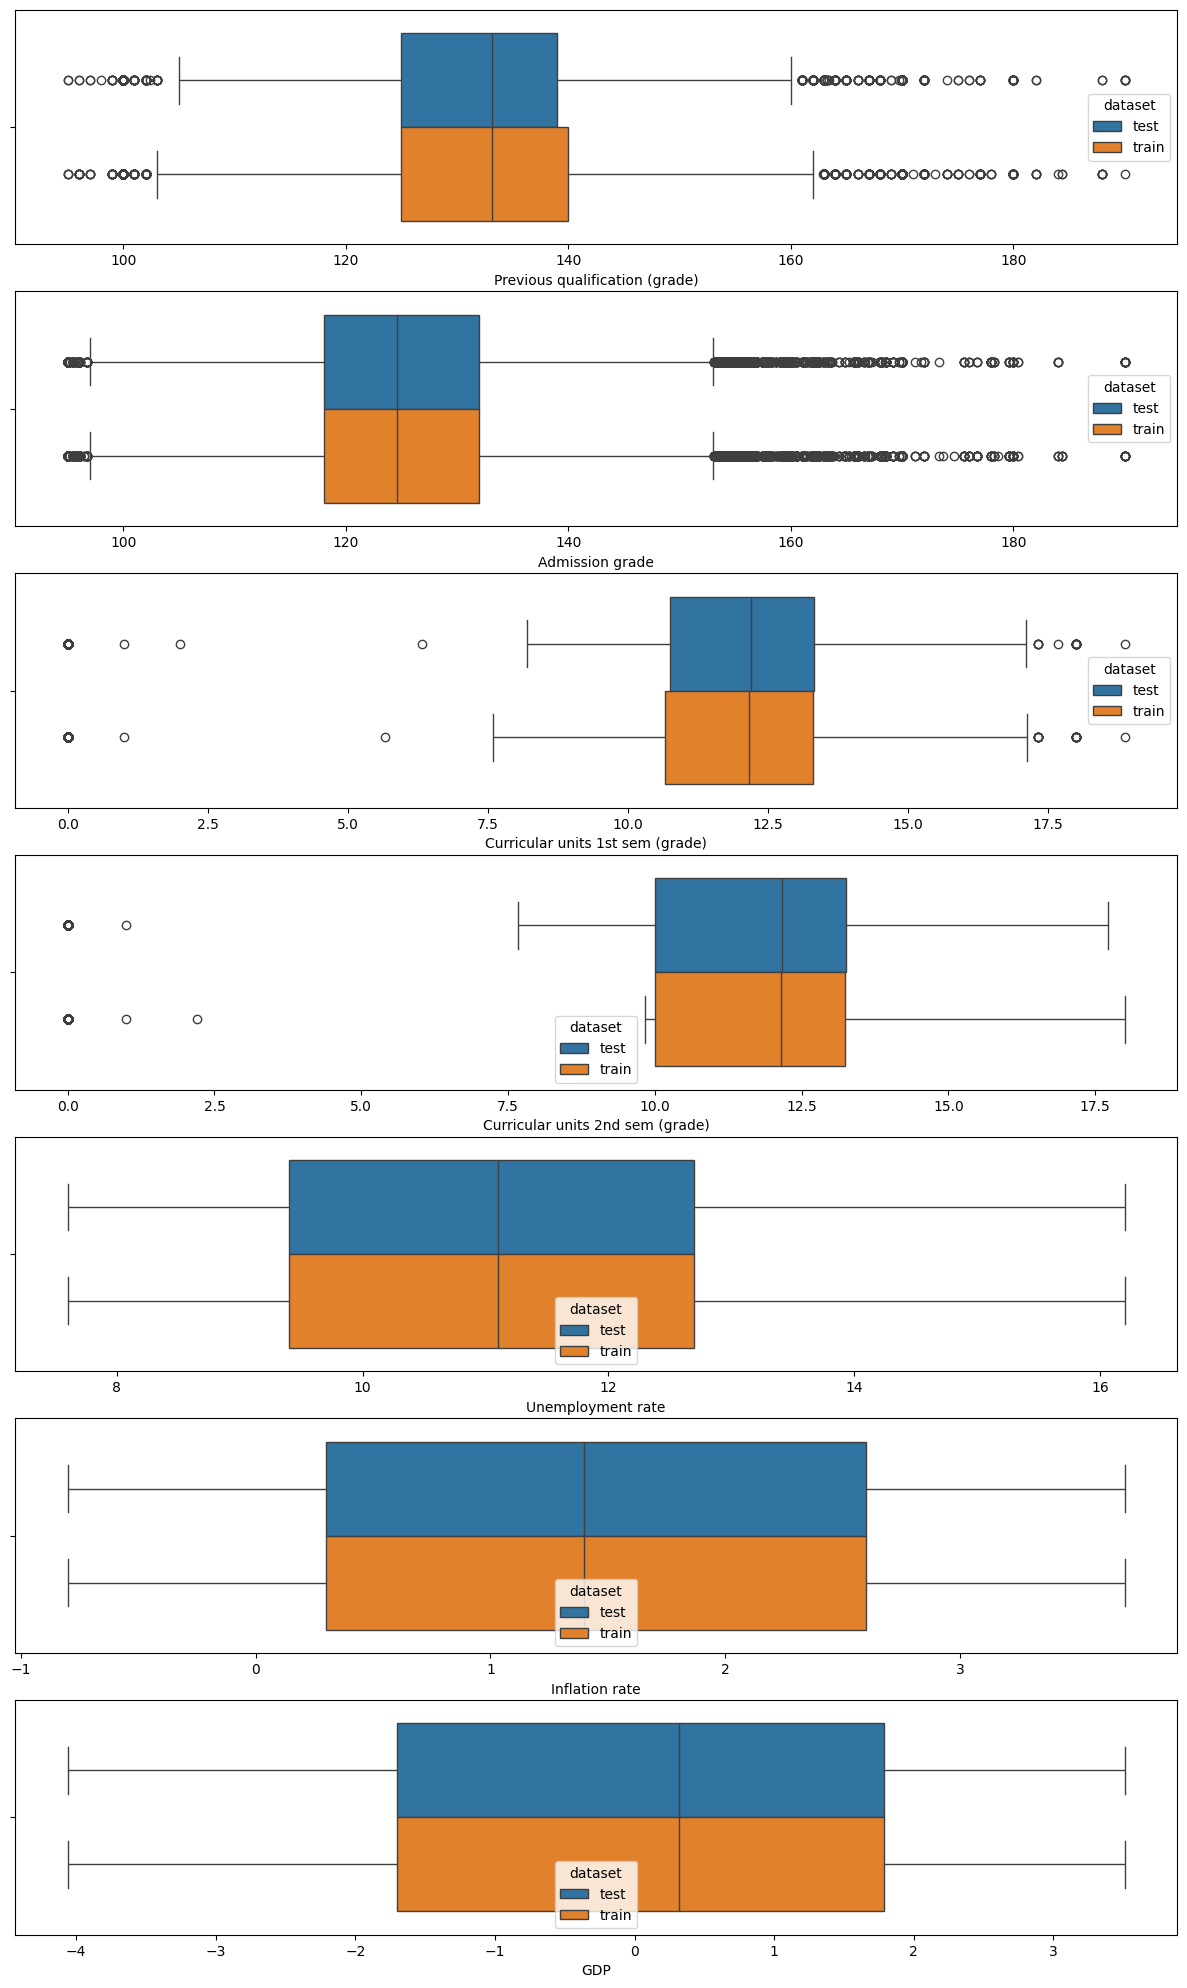

In [58]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.boxplot(data=df_complete, x=num_variables[i], hue='dataset', ax=axes[i])

They all seem very similar with the exception of 'Curricular units 2nd sem (grade)' whose 25 percentil is higher in test than in train.

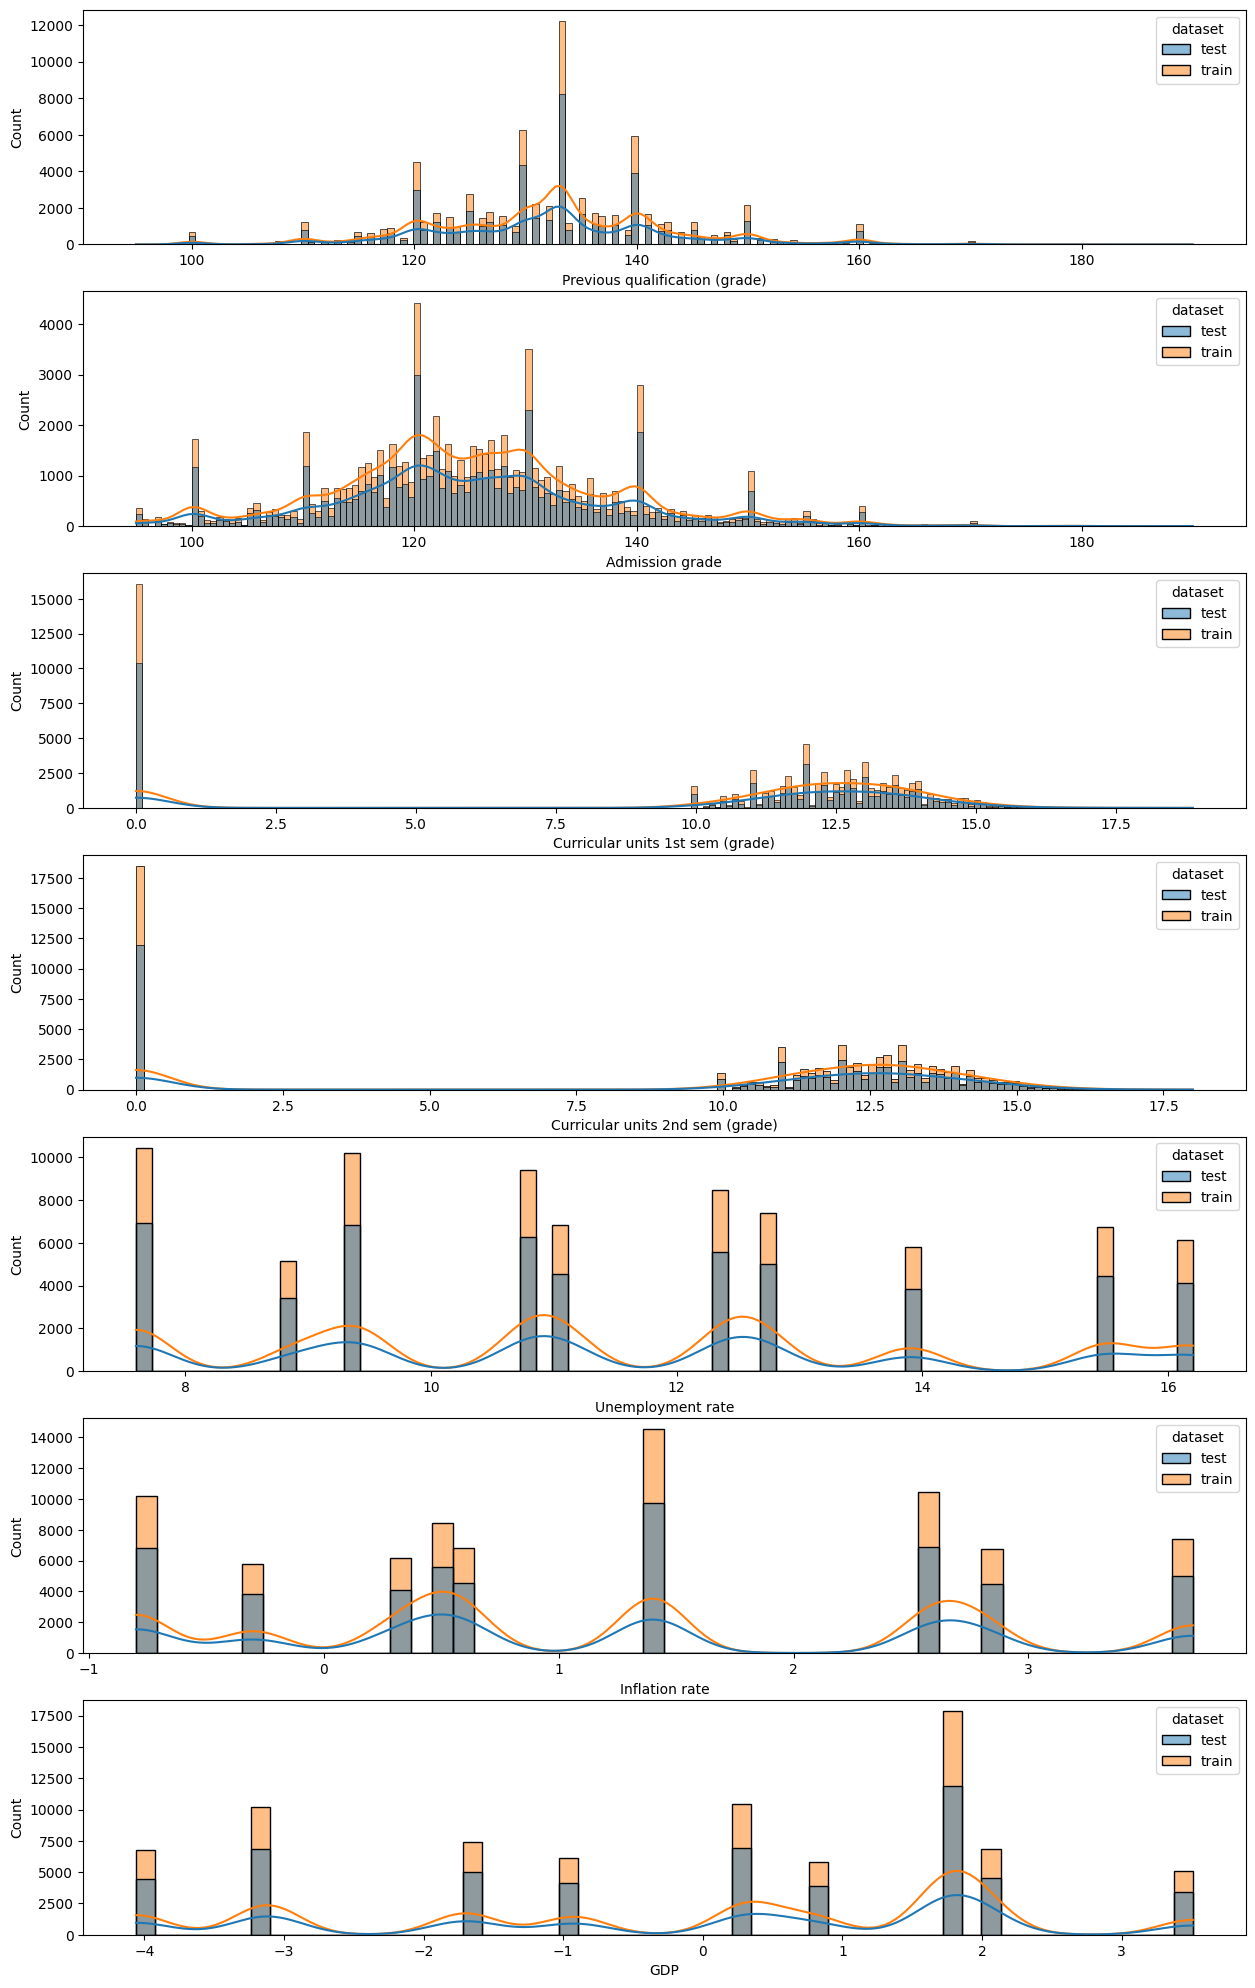

In [60]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.histplot(data=df_complete, x=num_variables[i], hue='dataset', ax=axes[i], kde=True)

They all look similar.

### How does getting zero grade predicts the outcome?

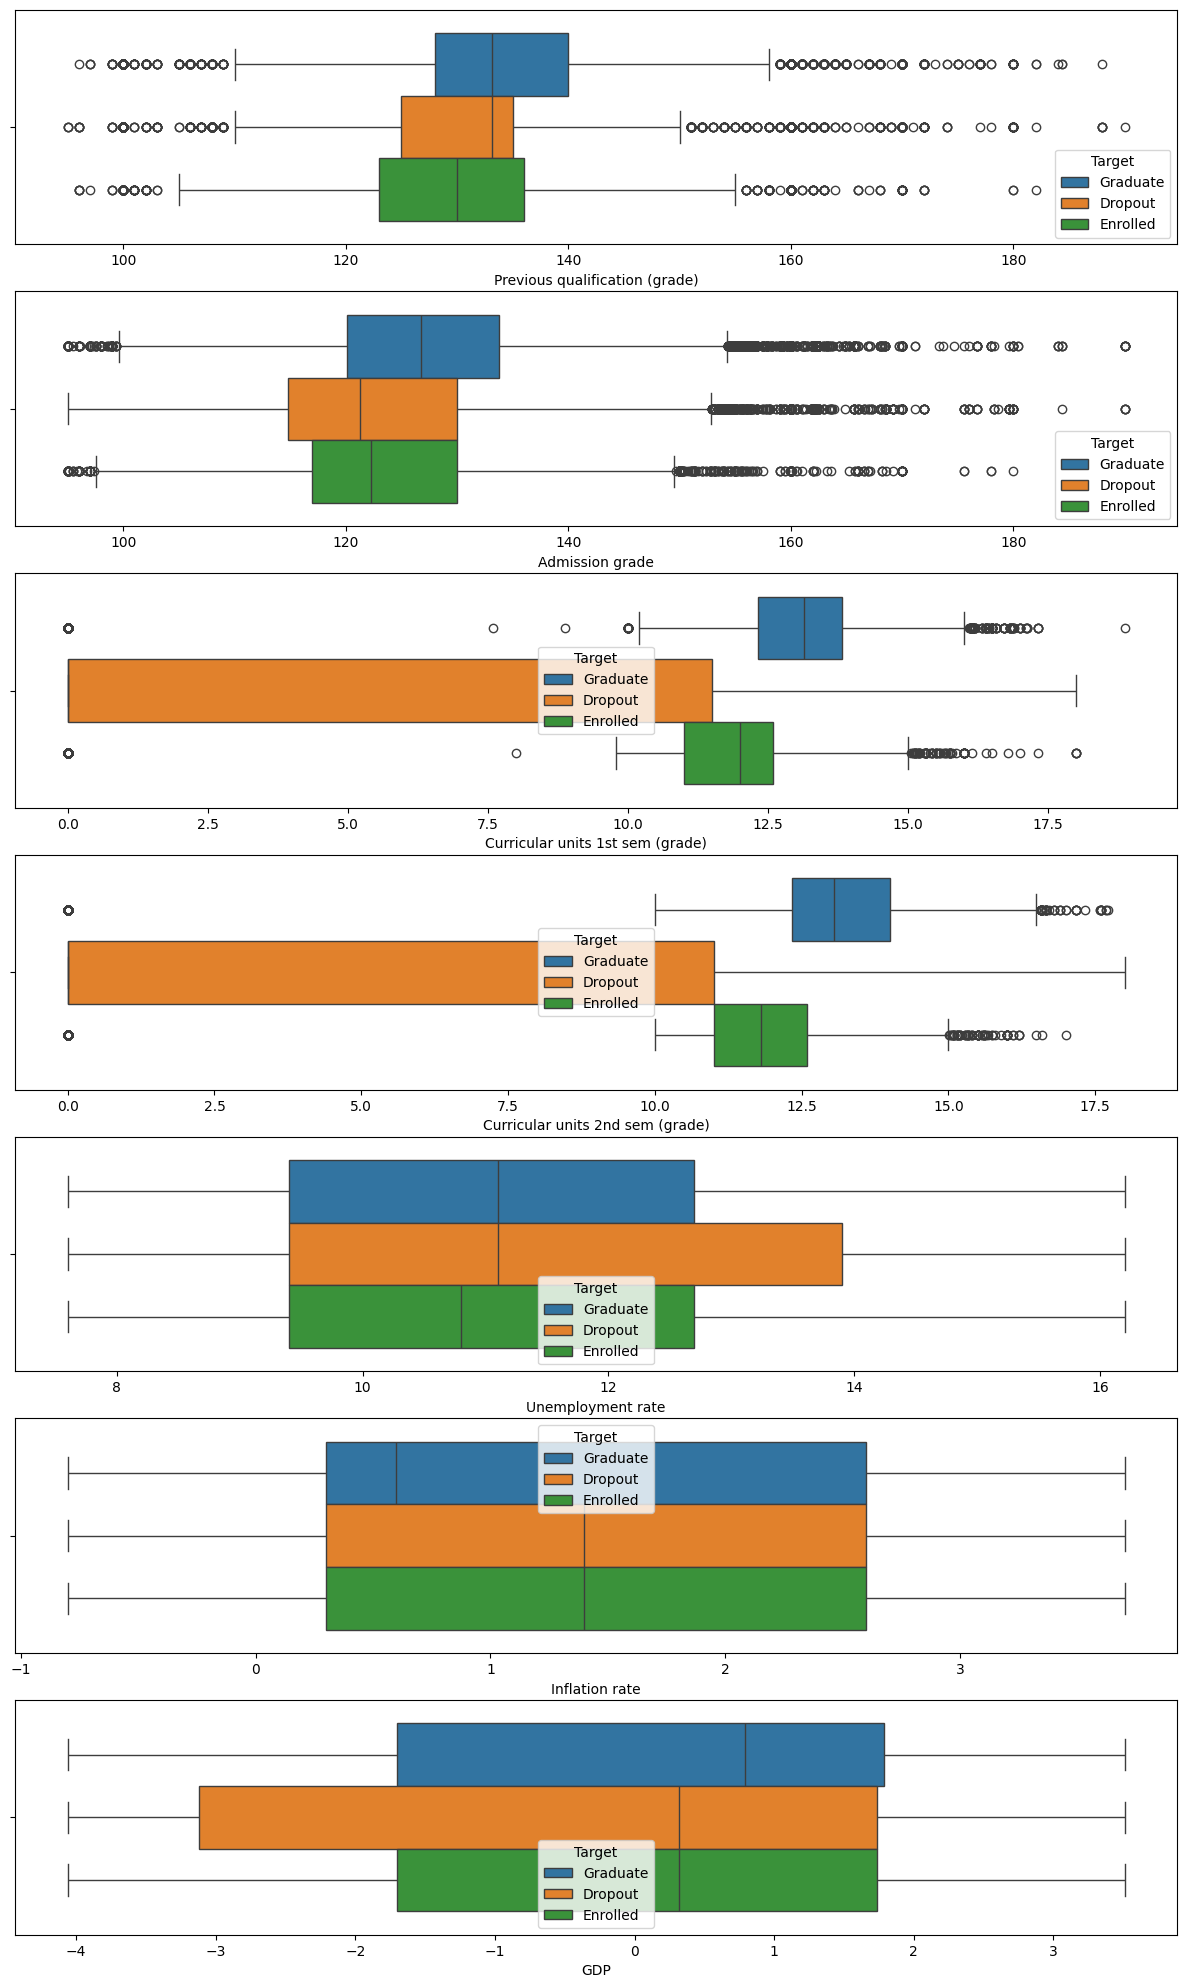

In [64]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.boxplot(data=df, x=num_variables[i], hue='Target', ax=axes[i])

In [65]:
df[df['Curricular units 1st sem (grade)'] < 10.0]['Target'].value_counts()

Target
Dropout     14857
Enrolled      635
Graduate      550
Name: count, dtype: int64

In [69]:
df[df['Curricular units 1st sem (grade)'] >= 10.0]['Target'].value_counts()

Target
Graduate    35732
Enrolled    14305
Dropout     10439
Name: count, dtype: int64

In [71]:
14857/(14857+635+550) # dropout

0.926131405061713

In [73]:
(35732+14306)/(14305+10439+35732) # enrolled + graduate

0.8274026059924598

In [67]:
df[df['Curricular units 2nd sem (grade)'] < 10.0]['Target'].value_counts()

Target
Dropout     17259
Enrolled      669
Graduate      555
Name: count, dtype: int64

In [70]:
df[df['Curricular units 2nd sem (grade)'] >= 10.0]['Target'].value_counts()

Target
Graduate    35727
Enrolled    14271
Dropout      8037
Name: count, dtype: int64

In [68]:
17259/(17259+669+555)

0.9337769842558026

The average grades of each semester look like a very good indicator of droupouts.

Would it be benefitial the creation of a binary variable of "Grades >= 10.0"?

# Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [34]:
cat_variables = df.drop('Target', axis=1).select_dtypes(include=['category', 'bool']).columns.to_list()
num_variables = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [36]:
ct = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_variables),
    ('num', StandardScaler(), num_variables)
])

X_trans = ct.fit_transform(X)

In [38]:
col_names = ct.named_transformers_['cat'].get_feature_names_out().tolist()+ct.named_transformers_['num'].get_feature_names_out().tolist()
X_trans = pd.DataFrame.sparse.from_spmatrix(X_trans, columns=col_names)

In [40]:
X_trans.head()

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_2,Application mode_3,Application mode_4,Application mode_5,Application mode_7,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,-0.066933,0.718660,0.505317,-0.135127,-0.158418,-0.449110,0.933176
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,0.504003,-1.445110,-1.735681,-0.135127,-0.158418,-0.449110,0.933176
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,-2.065210,-1.445110,-1.735681,-0.135127,1.763675,-0.663578,-0.372698
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,1.270048,1.074940,1.079288,0.575895,-0.135127,-0.158418,-0.449110,0.933176
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.655484,1.360408,0.718660,0.596330,-0.135127,-1.477502,0.980680,0.178079


# Feature Selection

In [41]:
remove_cols = ['Application mode_4', 'Application mode_9', 'Application mode_12',
       'Application mode_26', 'Course_39', 'Course_979',
       'Previous qualification_36', 'Previous qualification_37',
       'Nacionality_17', "Mother's qualification_7",
       "Mother's qualification_8", "Mother's qualification_15",
       "Mother's qualification_27", "Mother's qualification_28",
       "Father's qualification_15", "Father's qualification_20",
       "Father's qualification_23", "Father's qualification_24",
       "Father's qualification_44", "Mother's occupation_11",
       "Mother's occupation_38", "Mother's occupation_101",
       "Mother's occupation_103", "Mother's occupation_127",
       "Mother's occupation_163", "Mother's occupation_172",
       "Father's occupation_12", "Father's occupation_13",
       "Father's occupation_19", "Father's occupation_22",
       "Father's occupation_39", "Father's occupation_96",
       "Father's occupation_132", "Father's occupation_148",
       "Father's occupation_191"]

In [42]:
X_trans.drop(remove_cols, axis=1, inplace=True)

# Optuna

In [164]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create a RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    kf = KFold(n_splits=5)
    acc = [] 

    # Train the model
    for i, (train_index, test_index) in enumerate(kf.split(X_trans)):
        print(f'Kfold: {i}')
        clf.fit(X_trans.iloc[train_index], y[train_index])
        y_pred = clf.predict(X_trans.iloc[test_index])
        acc.append(accuracy_score(y[test_index], y_pred))
    
    # Calculate accuracy
    accuracy = np.mean(acc)
    
    return accuracy


In [ ]:
# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding accuracy
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)


# AutoGluon

In [47]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [48]:
df_autogluon = X_trans
df_autogluon['y'] = y
df_autogluon = TabularDataset(df_autogluon)
df_autogluon.head()

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_2,Application mode_3,Application mode_5,Application mode_7,Application mode_10,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.146765,0.040921,-0.066933,0.718660,0.505317,-0.135127,-0.158418,-0.449110,0.933176,Graduate
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.146765,0.040921,0.504003,-1.445110,-1.735681,-0.135127,-0.158418,-0.449110,0.933176,Dropout
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.146765,0.040921,-2.065210,-1.445110,-1.735681,-0.135127,1.763675,-0.663578,-0.372698,Dropout
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.146765,1.270048,1.074940,1.079288,0.575895,-0.135127,-0.158418,-0.449110,0.933176,Enrolled
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.146765,0.655484,1.360408,0.718660,0.596330,-0.135127,-1.477502,0.980680,0.178079,Graduate


In [49]:
predictor = TabularPredictor(label='y', eval_metric='accuracy').fit(df_autogluon, time_limit=7200)

No path specified. Models will be saved in: "AutogluonModels/ag-20240613_191157"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "AutogluonModels/ag-20240613_191157"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #4355-Microsoft Thu Apr 12 17:37:00

In [50]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.8320,accuracy,0.025514,3.229827,0.025514,3.229827,1,True,2
1,WeightedEnsemble_L2,0.8320,accuracy,0.027413,3.470585,0.001899,0.240758,2,True,9
2,LightGBMXT,0.8292,accuracy,0.030754,3.506892,0.030754,3.506892,1,True,1
3,LightGBMLarge,0.8292,accuracy,0.077512,9.931460,0.077512,9.931460,1,True,8
4,XGBoost,0.8288,accuracy,0.117427,4.664266,0.117427,4.664266,1,True,7
5,CatBoost,0.8264,accuracy,0.006884,8.449824,0.006884,8.449824,1,True,4
6,ExtraTreesGini,0.8180,accuracy,0.053968,5.476468,0.053968,5.476468,1,True,5
7,RandomForestGini,0.8180,accuracy,0.063989,6.832257,0.063989,6.832257,1,True,3
8,ExtraTreesEntr,0.8108,accuracy,0.050565,5.190304,0.050565,5.190304,1,True,6


# Submission

In [8]:
df_test = pd.read_csv('./datasets/test.csv')
df_test = convert_feature_types(df_test)
id = df_test.pop('id')

df_test = ct.transform(df_test)
df_test = pd.DataFrame.sparse.from_spmatrix(df_test, columns=col_names)
df_test.drop(remove_cols, axis=1, inplace=True)


NameError: name 'ct' is not defined

In [69]:
df_test

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_2,Application mode_3,Application mode_5,Application mode_7,Application mode_10,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,1.270048,-2.065210,-1.445110,-1.735681,-0.135127,0.896848,-1.092515,0.386841
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,-0.352401,0.718660,0.698506,-0.135127,-0.158418,-0.449110,0.933176
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,1.074940,0.358031,0.247731,-0.135127,1.499858,1.123659,-1.767406
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,3.065833,1.270048,1.931344,0.358031,0.247731,-0.135127,-0.987556,0.122806,1.594996
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,0.504003,-0.002597,0.187627,4.192905,-1.477502,0.980680,0.178079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,-3.646459,-2.065210,-1.445110,-1.735681,-0.135127,1.499858,1.123659,-1.767406
51008,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,-0.573642,-0.637869,-1.445110,-1.735681,-0.135127,-0.799116,-1.449963,-1.349882
51009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,-3.646459,-2.065210,-1.445110,-1.735681,-0.135127,1.499858,1.123659,-1.767406
51010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,0.504003,-0.363225,0.608351,-0.135127,-1.477502,0.980680,0.178079


In [ ]:
# values from Optuna
clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=27,
        min_samples_split=7,
        min_samples_leaf=1,
        random_state=42
    )

y_pred = clf.fit(X_trans, y).predict(df_test)

In [70]:
# autogluon
df_test = TabularDataset(df_test)
y_pred = predictor.predict(df_test)

In [71]:
len(y_pred.tolist())

51012

In [216]:
len(df_test)

51012

In [72]:
data = {'id': id.tolist(), 'Target': y_pred.tolist()}
submission = pd.DataFrame(data)
submission.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled


In [73]:
submission.to_csv('./submissions/autogluon_model_2.csv', index=False)